# Project Capstone: Which neighborhood to buy a house?

## Introduction

Investing in property has been a lucrative business over the past years. The average house prices in the, densely populated, Netherlands have been skyrocketing over the past years. An estimate done by several research institutions showed that between 2017 and 2019, the prices increased on average with  9.7%. This research will focus on the city Delft. “Why Delft?”, it is a beautiful city in the center of the Netherlands, with a strong technical university. This results in a population that is relatively young and therefore with many first-time buyers. This study will develop a model to determine good neighborhoods in Delft to settle for young adults and potentially have children. 


## Data Requirements:

In order to come up with a model that can predict if a neighborhood is suitable for a new family. We need to determine what is important for a new family. After a deep dive( and talking with the subject matter experts, aka. The author, cause I am in that situation), the following features have been selected:

*	Vegetation (Trees)
*	Water (canals and ponds)
*	Playgrounds
*	Venues (incl. object of interest)

Based on these features, we can develop a model and evaluate the attractiveness of a neighborhood in which we want to invest. The data should contain at least: 
*	Longitude and latitude, in order to decide in which neighborhood, they belong.
*	Count per neighborhood of the features discussed above. 
*	Open source, and freely accessible
*	We need GEO data on the city of Delft.


## Data collection & understanding: 

The above features were selected, among others, based on their availability. The municipality of Delft provides several open access data sets. These sources will cover: “Vegetation, Water, Playground”. The Four Square API will be used to collect venues per neighborhood. 

Before we can prepare the data, we need to study the different data sources:
*	Vegetation dataset: list of trees which are taken care of by the municipality, additional information includes longitude, latitude, height, shape, level of maintenance, type, age etc. 
*	 Water dataset: list of water sources such as locations of canals and ponds, the level of maintenance, if it needs mowing and the caretaker etc. 
*	Playgrounds dataset: playgrounds with longitude, latitude, size, level of maintenance, caretaker and year of development etc. 
*	Foursquare Api; Venues or object of interest within a certain radius. Additional information includes categories and names of the venues. 

The GEOdata per neighborhood is not available and has to be created from scratch. This is done using the tool: http://geojson.io/. With this tool, you can draw polygon on the map and later plot these polygons over the folium map. 
Data Preparation:
The opensource data needs little preparation they are already provided in easy handling formats such as csv and Json.


## Used packages:

In [333]:
import folium
from folium.features import DivIcon

import pandas as pd
from pandas.io.json import json_normalize

import json
import requests

from sklearn.cluster import KMeans
from sklearn import preprocessing

import numpy as np

## General Data Delft

General data from Delft has been collected by web searches

In [334]:
#location of the centers, area and population of each neighborhood
center_Location ={'Tanthof' : [51.982308,  4.351760,5.86,17126],
                  'Voorhof' : [51.996322, 4.344202,5.02,30003],
                  'Binnenstad' :[52.013576, 4.364522,4.49,44456],
                  'Buitenhof':[52.009339, 4.334157,2.06,17990],
                  'Schieweg_Zuid': [51.988527, 4.383054,2.26,8213]
                 } 
   
df_CL = pd.DataFrame(center_Location)
df_CL = df_CL.transpose()
df_CL.rename(columns={0:'lat',1:'long',2:'Square Km',3:'Population'},inplace=True)
df_CL['Pop. density (Pop./KM)'] = round(df_CL['Population']/ df_CL['Square Km'],-2)
df_CL

,lat,long,Square Km,Population,Pop. density (Pop./KM)
Tanthof,51.982308,4.351760,5.86,17126.0,2900.0
Voorhof,51.996322,4.344202,5.02,30003.0,6000.0
Binnenstad,52.013576,4.364522,4.49,44456.0,9900.0
Buitenhof,52.009339,4.334157,2.06,17990.0,8700.0
Schieweg_Zuid,51.988527,4.383054,2.26,8213.0,3600.0


### Let's explore Delft a little bit more. If we plot the above dataframe on a map of Delft, so we can understand Delft's layout a bit better

In [335]:
# Json file decribing the polygons of Delft. 
Wijken_delft_json = r'C:\Users\perin\OneDrive\Desktop\Kristian\Neighboroughed Delft_3.json'

#Coordinates of Delft
latitude = 52.0050
longitude = 4.3571

In [336]:
# create map of Delft using latitude and longitude values
map_Delft = folium.Map(location=[latitude, longitude], zoom_start=13,tiles='OpenStreetMap')

folium.GeoJson(Wijken_delft_json).add_to(map_Delft)

# Add the color for the chloropleth:
map_Delft.choropleth(
 geo_data= Wijken_delft_json,
 name='choropleth',
 data= df_CL,
 columns=[df_CL.index, 'Pop. density (Pop./KM)'],
 key_on='properties.name',
 fill_color='PuBuGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Population Density'
)
folium.LayerControl().add_to(map_Delft)

#add markers to map
for lat, lng, name in zip(df_CL['lat'], df_CL['long'], df_CL.index):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#4868FF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Delft)      

    folium.map.Marker(
        [lat,lng],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 15pt">%s</div>' % name
            )
    ).add_to(map_Delft)  
map_Delft

C:\Programs\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


As we can see on the map above, Delft Consist out of 5 neighborhoods. With 'Binnenstad' as the most densly populated area.

## Get Location of trees, playgrounds and water elements in Delft

##### In this section, we will collect the different data sources we will use for our further analysis
As mentioned in the previous sections, we will look into: 
*	Vegetation (Trees)
*	Water (canals and ponds)
*	Playgrounds

In [337]:
# Datasources
Trees = r'C:\Users\perin\Downloads\Bomen_in_beheer_door_gemeente_Delft.csv'
playground = r'C:\Users\perin\Downloads\Speelplekken.csv'
Water_elements_json = r'C:\Users\perin\Downloads\Wateren.geojson'

#reading the data in pandas DataFrame
df_playgroud_Delft = pd.read_csv(playground)
df_playgroud_Delft = df_playgroud_Delft

df_Trees_Delft = pd.read_csv(Trees)
df_Trees_Delft = df_Trees_Delft

#Reading the water data from a Json file this file will need some additional processing
with open(Water_elements_json) as json_file:
    water_data = json.load(json_file)

#create an empty list in which will contain the final input
Water_data= []

for i in range(0,len(water_data['features'])):
    Water_data.append([
        (water_data['features'][i]['properties']['ELEMENTNUMMER']),
        (water_data['features'][i]['properties']['WIJK']),
        (water_data['features'][i]['properties']['OPPERVLAK'])
        ])


df_water = pd.DataFrame(Water_data, columns=['ObjectID','Wijk','Area'])
df_total_water_per_wijk = df_water.groupby('Wijk').sum()
df_total_water_per_wijk = df_total_water_per_wijk.reset_index()

## Plotting the collected Tree data

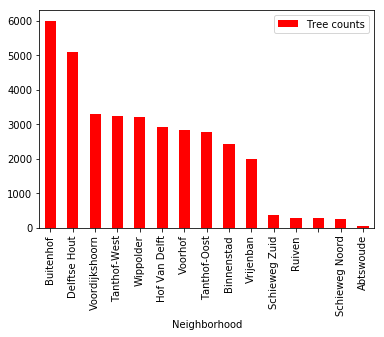

In [338]:
df_Trees_Delt_plt = df_Trees_Delft['WIJKNAAM'].value_counts().rename_axis('Neighborhood').reset_index(name='Tree counts')
df_Trees_Delt_plt.plot(kind='bar',x='Neighborhood',y='Tree counts',color='red')

As you can see, the dataframe data contains much more Neihborhoods as the ones defined in the pervious section. The neighborhoods have been split in to many sub-neighborhoods. e.g. east and west (oost en west). We will need to merge some neihborhoods. This does not only hold for the Tree data, but for all collected data. 

## Pre-processing neighborhood data via mapping tables

Merging several neighborhoods into the sections we devided in the first step

['Voorhof' 'Tanthof' 'Binnenstad' 'Buitenhof' 'Schieweg_Zuid']
['Buitenhof' 'Voorhof' 'Tanthof' 'Binnenstad' 'Schieweg_Zuid']
['Binnenstad' 'Voorhof' 'Buitenhof' 'Tanthof' 'Schieweg_Zuid']


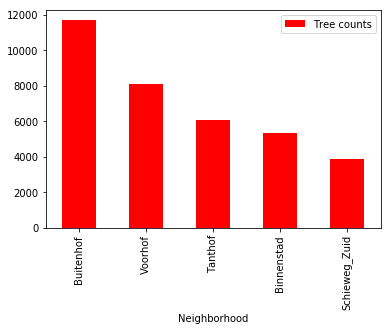

In [339]:
Tanthof = ['26 Abtswoude','Tanthof west 22','Tanthof Oost','Tanthof-West','Tanthof-Oost','Abtswoude','22 Tanthof-West','23 Tanthof-Oost'] 
Voorhof = ['24 Voorhof','Voorhof 24','Vrijenban 12','Voordijkshoorn 14','Voordijkshoorn','Voorhof','Vrijenban','12 Vrijenban','14 Voordijkshoorn']
Schieweg_Zuid = ['28 Wippolder','27 Schieweg','Schieweg','Harnaschpolder','Wippolder 28','Wippolder','Schieweg Zuid','Schieweg Noord']
Binnenstad=['Hof Van Delft','Binnenstad ','Hof Van Delft','Hof van Delft','11 Binnenstad','13 Hof van Delft']
Buitenhof=['29 Ruiven','25 Buitenhof','Buitenhof','Delftse Hout','Ruiven',' ','16 Delftse Hout']

Neighborhood_list = [Tanthof,Voorhof,Schieweg_Zuid,Binnenstad,Buitenhof]
Neighborhood_list_name_list = ['Tanthof','Voorhof','Schieweg_Zuid','Binnenstad','Buitenhof']

for i in range(0,len(Neighborhood_list)):
    df_Trees_Delft['WIJKNAAM'].replace(Neighborhood_list[i],Neighborhood_list_name_list[i],inplace = True)
    df_playgroud_Delft['Wijk'].replace(Neighborhood_list[i],Neighborhood_list_name_list[i],inplace = True)
    df_total_water_per_wijk['Wijk'].replace(Neighborhood_list[i],Neighborhood_list_name_list[i],inplace = True)
    
print(df_playgroud_Delft['Wijk'].unique())
print(df_Trees_Delft['WIJKNAAM'].unique())
print(df_total_water_per_wijk['Wijk'].unique())

#Lets plot the data again
df_Trees_Delt_plt = df_Trees_Delft['WIJKNAAM'].value_counts().rename_axis('Neighborhood').reset_index(name='Tree counts')
df_Trees_Delt_plt.plot(kind='bar',x='Neighborhood',y='Tree counts',color='red')

Let's merge all data cleaned data in one dataframe

In [340]:
df_Delft = pd.concat([df_CL,
                     df_Trees_Delft['WIJKNAAM'].value_counts(),
                     df_playgroud_Delft['Wijk'].value_counts(),
                     df_total_water_per_wijk.groupby('Wijk').sum()],
                     axis=1, join='inner')
                     
df_Delft.rename(columns = {'WIJKNAAM':'Trees','Wijk':'Playgrounds','Area':'Water_Area'},inplace =True) 
df_Delft

,lat,long,Square Km,Population,Pop. density (Pop./KM),Trees,Playgrounds,Water_Area
Tanthof,51.982308,4.351760,5.86,17126.0,2900.0,6081,52,143141.75
Voorhof,51.996322,4.344202,5.02,30003.0,6000.0,8105,53,280144.68
Binnenstad,52.013576,4.364522,4.49,44456.0,9900.0,5340,33,51698.36
Buitenhof,52.009339,4.334157,2.06,17990.0,8700.0,11673,33,589634.83
Schieweg_Zuid,51.988527,4.383054,2.26,8213.0,3600.0,3856,32,58019.08


The prelimiary output of our analysis is shown in the table above. We still need to extend it based on the venues in the proximity

## Foursquare: venue and object of interest data

Using the Foursquare API, we collect all venues and Object of interest data in the proximity of the central locations in each neighborhood

In [341]:
#login data for Foursquare API
CLIENT_ID='UUTO0VO5CFK4L4XRUPKU0ZMIOYA041AWQ3MVZYJIOPJZAERU'
CLIENT_SECRET='EY5P1YAVKYSAMKPTGKXRXHXEMMJIF5DOHBXNBKOGB2P04CAW'
VERSION = '20180605' # Foursquare API version
LIMIT = 100
#this function will give nearby venues in a radius of 800ft.
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Here we loop through the all locations and return the all the veneus in that area

In [342]:
Delft_venues = getNearbyVenues(names=df_CL.index,
                                   latitudes=df_CL['lat'],
                                   longitudes=df_CL['long']
                                  )

Tanthof
Voorhof
Binnenstad
Buitenhof
Schieweg_Zuid


Lets look at some do some checks on each neighborhood. 

In [343]:
Delft_venues.groupby(['Neighborhood','Venue Category']).count()


Neighborhood Latitude  \
Neighborhood  Venue Category                                   
Binnenstad    Athletics & Sports                           2   
              BBQ Joint                                    1   
              Bakery                                       3   
              Bar                                          4   
              Beer Store                                   1   
              Bistro                                       1   
              Bookstore                                    2   
              Bowling Alley                                1   
              Breakfast Spot                               1   
              Brewery                                      1   
              Bridge                                       1   
              Butcher                                      1   
              Café                                         6   
              Cheese Shop                                  1   
              Chocolate Shop                               2   
              Church                                       1   
              Clothing Store                               2   
              Coffee Shop                                  2   
              Comfort Food Restaurant                      1   
              Cupcake Shop                                 1   
              Department Store                             1   
              Dessert Shop                                 1   
              Diner                                        1   
              Dutch Restaurant                             1   
              Electronics Store                            1   
              Fast Food Restaurant                         1   
              Food                                         1   
              Food Truck                                   1   
              French Restaurant                            4   
              Furniture / Home Store                       1   
...                                                      ...   
Schieweg_Zuid Stadium                                      1   
              Tennis Court                                 1   
Tanthof       BBQ Joint                                    1   
              Bus Stop                                     2   
              Department Store                             1   
              Fast Food Restaurant                         3   
              Light Rail Station                           1   
              Park                                         3   
              Shop & Service                               1   
              Supermarket                                  3   
              Tram Station                                 3   
Voorhof       Asian Restaurant                             1   
              Board Shop                                   1   
              Bowling Alley                                1   
              Bus Stop                                     1   
              Chinese Restaurant                           1   
              Department Store                             1   
              Discount Store                               1   
              Drugstore                                    1   
              Furniture / Home Store                       1   
              Gym                                          2   
              Jewelry Store                                1   
              Light Rail Station                           1   
              Park                                         1   
              Pool Hall                                    1   
              Sandwich Place                               1   
              Shopping Mall                                1   
              Skate Park                                   1   
              Supermarket                                  3   
              Tram Station                                 1   

      

## data pre-processing for kmn clustering¶


We will use KMN clustering to determine how simular the different neighborhoods are to each other

In [344]:
# one hot encoding
Delft_onehot = pd.get_dummies(Delft_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Delft_onehot['Neighborhood'] = Delft_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Delft_onehot.columns[-1]] + list(Delft_onehot.columns[:-1])
Delft_onehot = Delft_onehot[fixed_columns]


Here we will determine the frequency of each venue per neighborhood

In [345]:
Delft_grouped = Delft_onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 5

for hood in Delft_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Delft_grouped[Delft_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Binnenstad----
               venue  freq
0               Café  0.06
1                Pub  0.04
2              Plaza  0.04
3                Bar  0.04
4  French Restaurant  0.04


----Buitenhof----
          venue  freq
0      Pharmacy  0.25
1   Supermarket  0.25
2   Pizza Place  0.12
3  Hockey Field  0.12
4        Bakery  0.12


----Schieweg_Zuid----
              venue  freq
0  Department Store  0.14
1      Hockey Field  0.14
2      Tennis Court  0.14
3               Gym  0.14
4           Stadium  0.14


----Tanthof----
                  venue  freq
0          Tram Station  0.17
1                  Park  0.17
2           Supermarket  0.17
3  Fast Food Restaurant  0.17
4              Bus Stop  0.11


----Voorhof----
              venue  freq
0       Supermarket  0.14
1               Gym  0.09
2  Asian Restaurant  0.05
3        Skate Park  0.05
4  Department Store  0.05




In [346]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Delft_grouped['Neighborhood']

for ind in np.arange(Delft_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Delft_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.shape

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Binnenstad,Café,French Restaurant,Bar,Pub,Plaza,Bakery,Movie Theater,Sandwich Place,Restaurant,Coffee Shop
1,Buitenhof,Supermarket,Pharmacy,Hockey Field,Park,Pizza Place,Bakery,Discount Store,Clothing Store,Coffee Shop,Comfort Food Restaurant
2,Schieweg_Zuid,Hockey Field,Stadium,Department Store,Bus Stop,Sandwich Place,Gym,Tennis Court,Bar,Drugstore,Comfort Food Restaurant
3,Tanthof,Park,Fast Food Restaurant,Tram Station,Supermarket,Bus Stop,Department Store,Light Rail Station,Shop & Service,BBQ Joint,Food
4,Voorhof,Supermarket,Gym,Asian Restaurant,Bowling Alley,Tram Station,Drugstore,Discount Store,Department Store,Jewelry Store,Light Rail Station


## Clustering of neighbourhood

We will cluster the neighbourhood in three clusters. After some additional research( not shown here) we determined that three was a good seperation number

In [347]:
# set number of clusters
kclusters = 3

Delft_grouped_clustering = Delft_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Delft_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)

In [348]:
# merge the cluster data with the previously obtained dataframe to get the whole picture
Delft_merged = df_Delft
neighborhoods_venues_sorted.rename(columns ={'Neighborhood':'Wijk'},inplace=True)
neighborhoods_venues_sorted.set_index('Wijk',inplace=True)
Delft_merged = Delft_merged.join(neighborhoods_venues_sorted)
Delft_merged

,lat,long,Square Km,Population,Pop. density (Pop./KM),Trees,Playgrounds,Water_Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Tanthof,51.982308,4.351760,5.86,17126.0,2900.0,6081,52,143141.75,0,Park,Fast Food Restaurant,Tram Station,Supermarket,Bus Stop,Department Store,Light Rail Station,Shop & Service,BBQ Joint,Food
Voorhof,51.996322,4.344202,5.02,30003.0,6000.0,8105,53,280144.68,0,Supermarket,Gym,Asian Restaurant,Bowling Alley,Tram Station,Drugstore,Discount Store,Department Store,Jewelry Store,Light Rail Station
Binnenstad,52.013576,4.364522,4.49,44456.0,9900.0,5340,33,51698.36,0,Café,French Restaurant,Bar,Pub,Plaza,Bakery,Movie Theater,Sandwich Place,Restaurant,Coffee Shop
Buitenhof,52.009339,4.334157,2.06,17990.0,8700.0,11673,33,589634.83,2,Supermarket,Pharmacy,Hockey Field,Park,Pizza Place,Bakery,Discount Store,Clothing Store,Coffee Shop,Comfort Food Restaurant
Schieweg_Zuid,51.988527,4.383054,2.26,8213.0,3600.0,3856,32,58019.08,1,Hockey Field,Stadium,Department Store,Bus Stop,Sandwich Place,Gym,Tennis Court,Bar,Drugstore,Comfort Food Restaurant


This dataset will be used to determine the overall attractiveness for each neighborhood. 

## Normalization  and data prep for Attractiveness model

here we created the final (data) format to design our model

In [349]:
df_Delft_Model = Delft_merged[['Square Km','Pop. density (Pop./KM)','Trees','Playgrounds','Water_Area','Cluster Labels']]
df_Delft_Model['Cluster Labels'].replace({0:'Restuarant heavy',1:'Sport area heavy',2:'Shop heavy Area'},inplace =True)

df_Delft_Model_f = df_Delft_Model[['Pop. density (Pop./KM)','Square Km']].join(
    round(df_Delft_Model[['Trees','Playgrounds','Water_Area']].div(df_Delft_Model['Square Km'], axis=0)))
    
df_Delft_Model_f.rename(columns={'Trees':'Trees/km','Playgrounds':'Playground/km','Water_Area':'Water_Area/km'},inplace=True)

#normalize the data
columns_name =df_Delft_Model_f.columns
index_names = df_Delft_Model_f.index

x = df_Delft_Model_f.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

#rename columns and index
df = pd.DataFrame(x_scaled,columns=columns_name,index=index_names)
df_Delft_Final_norm = df.join(df_Delft_Model['Cluster Labels'])
df_Delft_Final_norm

C:\Programs\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Pop. density (Pop./KM),Square Km,Trees/km,Playground/km,Water_Area/km,Cluster Labels
Tanthof,0.000000,1.000000,0.000000,0.222222,0.047005,Restuarant heavy
Voorhof,0.442857,0.778947,0.124649,0.444444,0.161228,Restuarant heavy
Binnenstad,1.000000,0.639474,0.032620,0.000000,0.000000,Restuarant heavy
Buitenhof,0.828571,0.000000,1.000000,1.000000,1.000000,Shop heavy Area
Schieweg_Zuid,0.100000,0.052632,0.144308,0.777778,0.051537,Sport area heavy


## Cluster values evaluation

The KMN-model provided three cluster, meaning neighborhoods which are simular. Based on my **personal** preference, I will assign a certain weight to that value.Proximity to shops are very important to us when we want to go to do grocery shopping. Sports & restaurants facilities, we enjoy but dont need necessarily in our neighborhood. That is why we came up with the following valuations
* v1=2 Restuarant heavy
* v2=3 Shop heavy Area
* v3=1 Sport_area heavy


In [350]:
#assgined values

v1=2 #Restuarant heavy
v2=3 #Shop heavy Area
v3=1 #Sport_area heavy

df_Delft_Final_norm['cluster_values'] = df_Delft_Final_norm['Cluster Labels']
df_Delft_Final_norm['cluster_values'].replace({'Restuarant heavy':v1,'Shop heavy Area':v2,'Sport area heavy':v3},inplace=True)
df_Delft_Final_norm


,Pop. density (Pop./KM),Square Km,Trees/km,Playground/km,Water_Area/km,Cluster Labels,cluster_values
Tanthof,0.000000,1.000000,0.000000,0.222222,0.047005,Restuarant heavy,2
Voorhof,0.442857,0.778947,0.124649,0.444444,0.161228,Restuarant heavy,2
Binnenstad,1.000000,0.639474,0.032620,0.000000,0.000000,Restuarant heavy,2
Buitenhof,0.828571,0.000000,1.000000,1.000000,1.000000,Shop heavy Area,3
Schieweg_Zuid,0.100000,0.052632,0.144308,0.777778,0.051537,Sport area heavy,1


## Model development: Determination of the neighborhood attraction index

This model assumes a very basic level model.
The Attraction index is calculated by the value in the normalized dataframe, multiplied by a weight factor.
where the weight is a __personal__ opinion

\begin{equation*}
Attraction-index = \left( \sum_{k=1}^n w_k p_k \right)
\end{equation*}

In [351]:
p0 = df_Delft_Final_norm['Pop. density (Pop./KM)']
p1 = df_Delft_Final_norm['Trees/km']
p2 = df_Delft_Final_norm['Playground/km']
p3 = df_Delft_Final_norm['Water_Area/km']
p4 = df_Delft_Final_norm['cluster_values']


w0= 4
w1= 1
w2= 3
w3= 5
w4 = 1 # already assigend weight to this value in previous step

#calculating the Attractiveness of a neibourhood
Attractiveness_list = (w0*p0) +(w1*p1) + (w2*p2) + (w3*p3) + (w4*p4) 
Attractiveness_list=Attractiveness_list/Attractiveness_list.max()

#convert output back to a dataframe
df_attraction_index =pd.DataFrame(Attractiveness_list)
df_attraction_index.rename(columns ={0:'Attraction_index'},inplace=True)
df_attraction_index

,Attraction_index
Tanthof,0.189476
Voorhof,0.394113
Binnenstad,0.393921
Buitenhof,1.000000
Schieweg_Zuid,0.270031


## Let's visualize our final result

In [352]:
# create map of Delft using latitude and longitude values
map_Delft = folium.Map(location=[latitude, longitude], zoom_start=13,tiles='OpenStreetMap')

folium.GeoJson(Wijken_delft_json).add_to(map_Delft)

# Add the color for the chloropleth:
map_Delft.choropleth(
 geo_data= Wijken_delft_json,
 name='choropleth',
 data= df_attraction_index,
 columns=[df_attraction_index.index, 'Attraction_index'],
 key_on='properties.name',
 fill_color='PuBuGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Population Density'
)
folium.LayerControl().add_to(map_Delft)

#add markers to map
for lat, lng, name in zip(df_CL['lat'], df_CL['long'], df_CL.index):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#4868FF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Delft)      

    folium.map.Marker(
        [lat,lng],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 15pt">%s</div>' % name
            )
    ).add_to(map_Delft)  
map_Delft

C:\Programs\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Discussion & Conclusion

Based on the created model, we can say that the best place to settle for our new home is the neighborhood __"Buitenhof"__. Many questions can be raised on the used model: Are the selected features appropriate? is the data complete? I think i can concluded that based on the available data, the results shown by the model are an rough indication. many more factors play a role; such as Crime numbers, average income, House values etc. Also the model is heavenly subjected to personal interpretation. What is important to the general, does not fit everyone. 
